In [4]:
import sys, os, glob
import matplotlib.pyplot as plt
import numpy as np
import torch

import models.rdmpy.blur as blur
import models.rdmpy.calibrate as calibrate

import models.forward as forward
import dataset.dataset as ds
import dataset.preprocess_data as prep_data
import utils.psf_utils as psf_utils
import utils.diffuser_utils as diffuser_utils
import utils.helper_functions as helper

device = "cuda:0"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Config setup
We will run this notebook from the same parameters in our training config. This allows for consistency between forward and recon models.

To find more about the config params, see the [training config template](config_files/TEMPLATE_training.yml).

In [5]:
config_path = "/home/cfoley_waller/defocam/SpectralDefocusCam/config_files/training/train_11_1_2023_lsi.yml"
config = helper.read_config(config_path)
device = helper.get_device(config["device"])

## Image transformation: simulating spatially invariant convolution
Our simulated [forward model](./models/forward.py) approximates a linear spatially invariant (LSI) system by performing a standard convolution with the input at each level of defocus. 

As an initial reconstruction step, we consider the adjoint of our system. Our LSI forward model is:

$$\mathbf b_i = \sum_{\lambda=0}^{K-1} \mathbf M_{\lambda}[x,y] \cdot  \text{crop} \Big( \mathbf h_i[x,y,\lambda] \stackrel{[x,y]}{*} \mathbf v[x,y,\lambda] \Big) = \mathbf A_i \mathbf v$$

and the adjoint is found as:

$$ \hat{\mathbf{v}}_i = \mathbf{h}_i^* \stackrel{[x,y]}{*} \text{pad}(\mathbf{M}_\lambda [x,y] \cdot \mathbf{b}_i) = \mathbf{A}_i^H\mathbf b_i$$


### Data preprocessing
First we must preprocess our data into a usable form. We use three datasets - [Harvards hyperspectral dataset](http://vision.seas.harvard.edu/hyperspec/), [Pavia Centre and University](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes), and the [Geissen Fruit Dataset](https://zenodo.org/record/2611806).

Note that this may take a while, as some of the data is quite large.

In [8]:
raw_datapath = "/home/cfoley_waller/10tb_extension/defocam/defocuscamdata/sample_data/"
processed_datapath = "/home/cfoley_waller/defocam/defocuscamdata/sample_data_preprocessed_lsi_11_3"

patchsize = config["patch_size"] # size of patches to chunk data - factor of cropsize for best results
num_channels = 30 # channels are linearly interpolated to fit this value from raw data - note same issue as above
prep_data.preprocess_harvard_data(os.path.join(raw_datapath, "harvard"), os.path.join(processed_datapath, "harvard_data"), patchsize, num_channels)
prep_data.preprocess_pavia_data(os.path.join(raw_datapath, "paviadata"), os.path.join(processed_datapath, "pavia_data"), patchsize, num_channels)
prep_data.preprocess_fruit_data(os.path.join(raw_datapath, "fruitdata/pca"), os.path.join(processed_datapath, "fruit_data"), patchsize, num_channels)

Preprocessing Harvard Data:   0%|          | 0/50 [00:00<?, ?it/s]

Preprocessing Fruit Data: 100%|██████████| 42/42 [04:33<00:00,  6.52s/it]


### Performing the forward and adjoint computations
Next we initialize our forward model, which uses our calibrated PSF data to perform a linear system-invariant (LsI) convolution. This is incorperated into the `Hfor()` and `Hadj()` methods of our [forward model](models/forward.py).

In [9]:
mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["forward_model_params"]["psf"]["padded_shape"],
    patch_size=config["patch_size"],
)
forward_model = forward.ForwardModel(mask, config["forward_model_params"], config["psf_dir"], device=device)

# The following should show whether we are using a varying or invariant Hfor and Hadj
print(forward_model.fwd, forward_model.adj)

<bound method ForwardModel.Hfor of ForwardModel()> <bound method ForwardModel.Hadj of ForwardModel()>


We can now use our forward model to build supervised learning pairs for each of our data samples. Doing this statically should drastically reduce training time, as the computation necessary to simulate our data is only done *once*, here.

**Note**: each simulated measurement stack is stored with the ground truth patch in its `.mat` file under a key defined by our forward model's params.

In [10]:
forward.build_data_pairs(os.path.join(processed_datapath, "harvard_data"), forward_model)
forward.build_data_pairs(os.path.join(processed_datapath, "pavia_data"), forward_model)
forward.build_data_pairs(os.path.join(processed_datapath, "fruit_data"), forward_model)

Generating Pair fruit_data: 100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


Just to get an idea of what we were doing doing, we can look at the models output from the last step.

torch.Size([3, 256, 256])


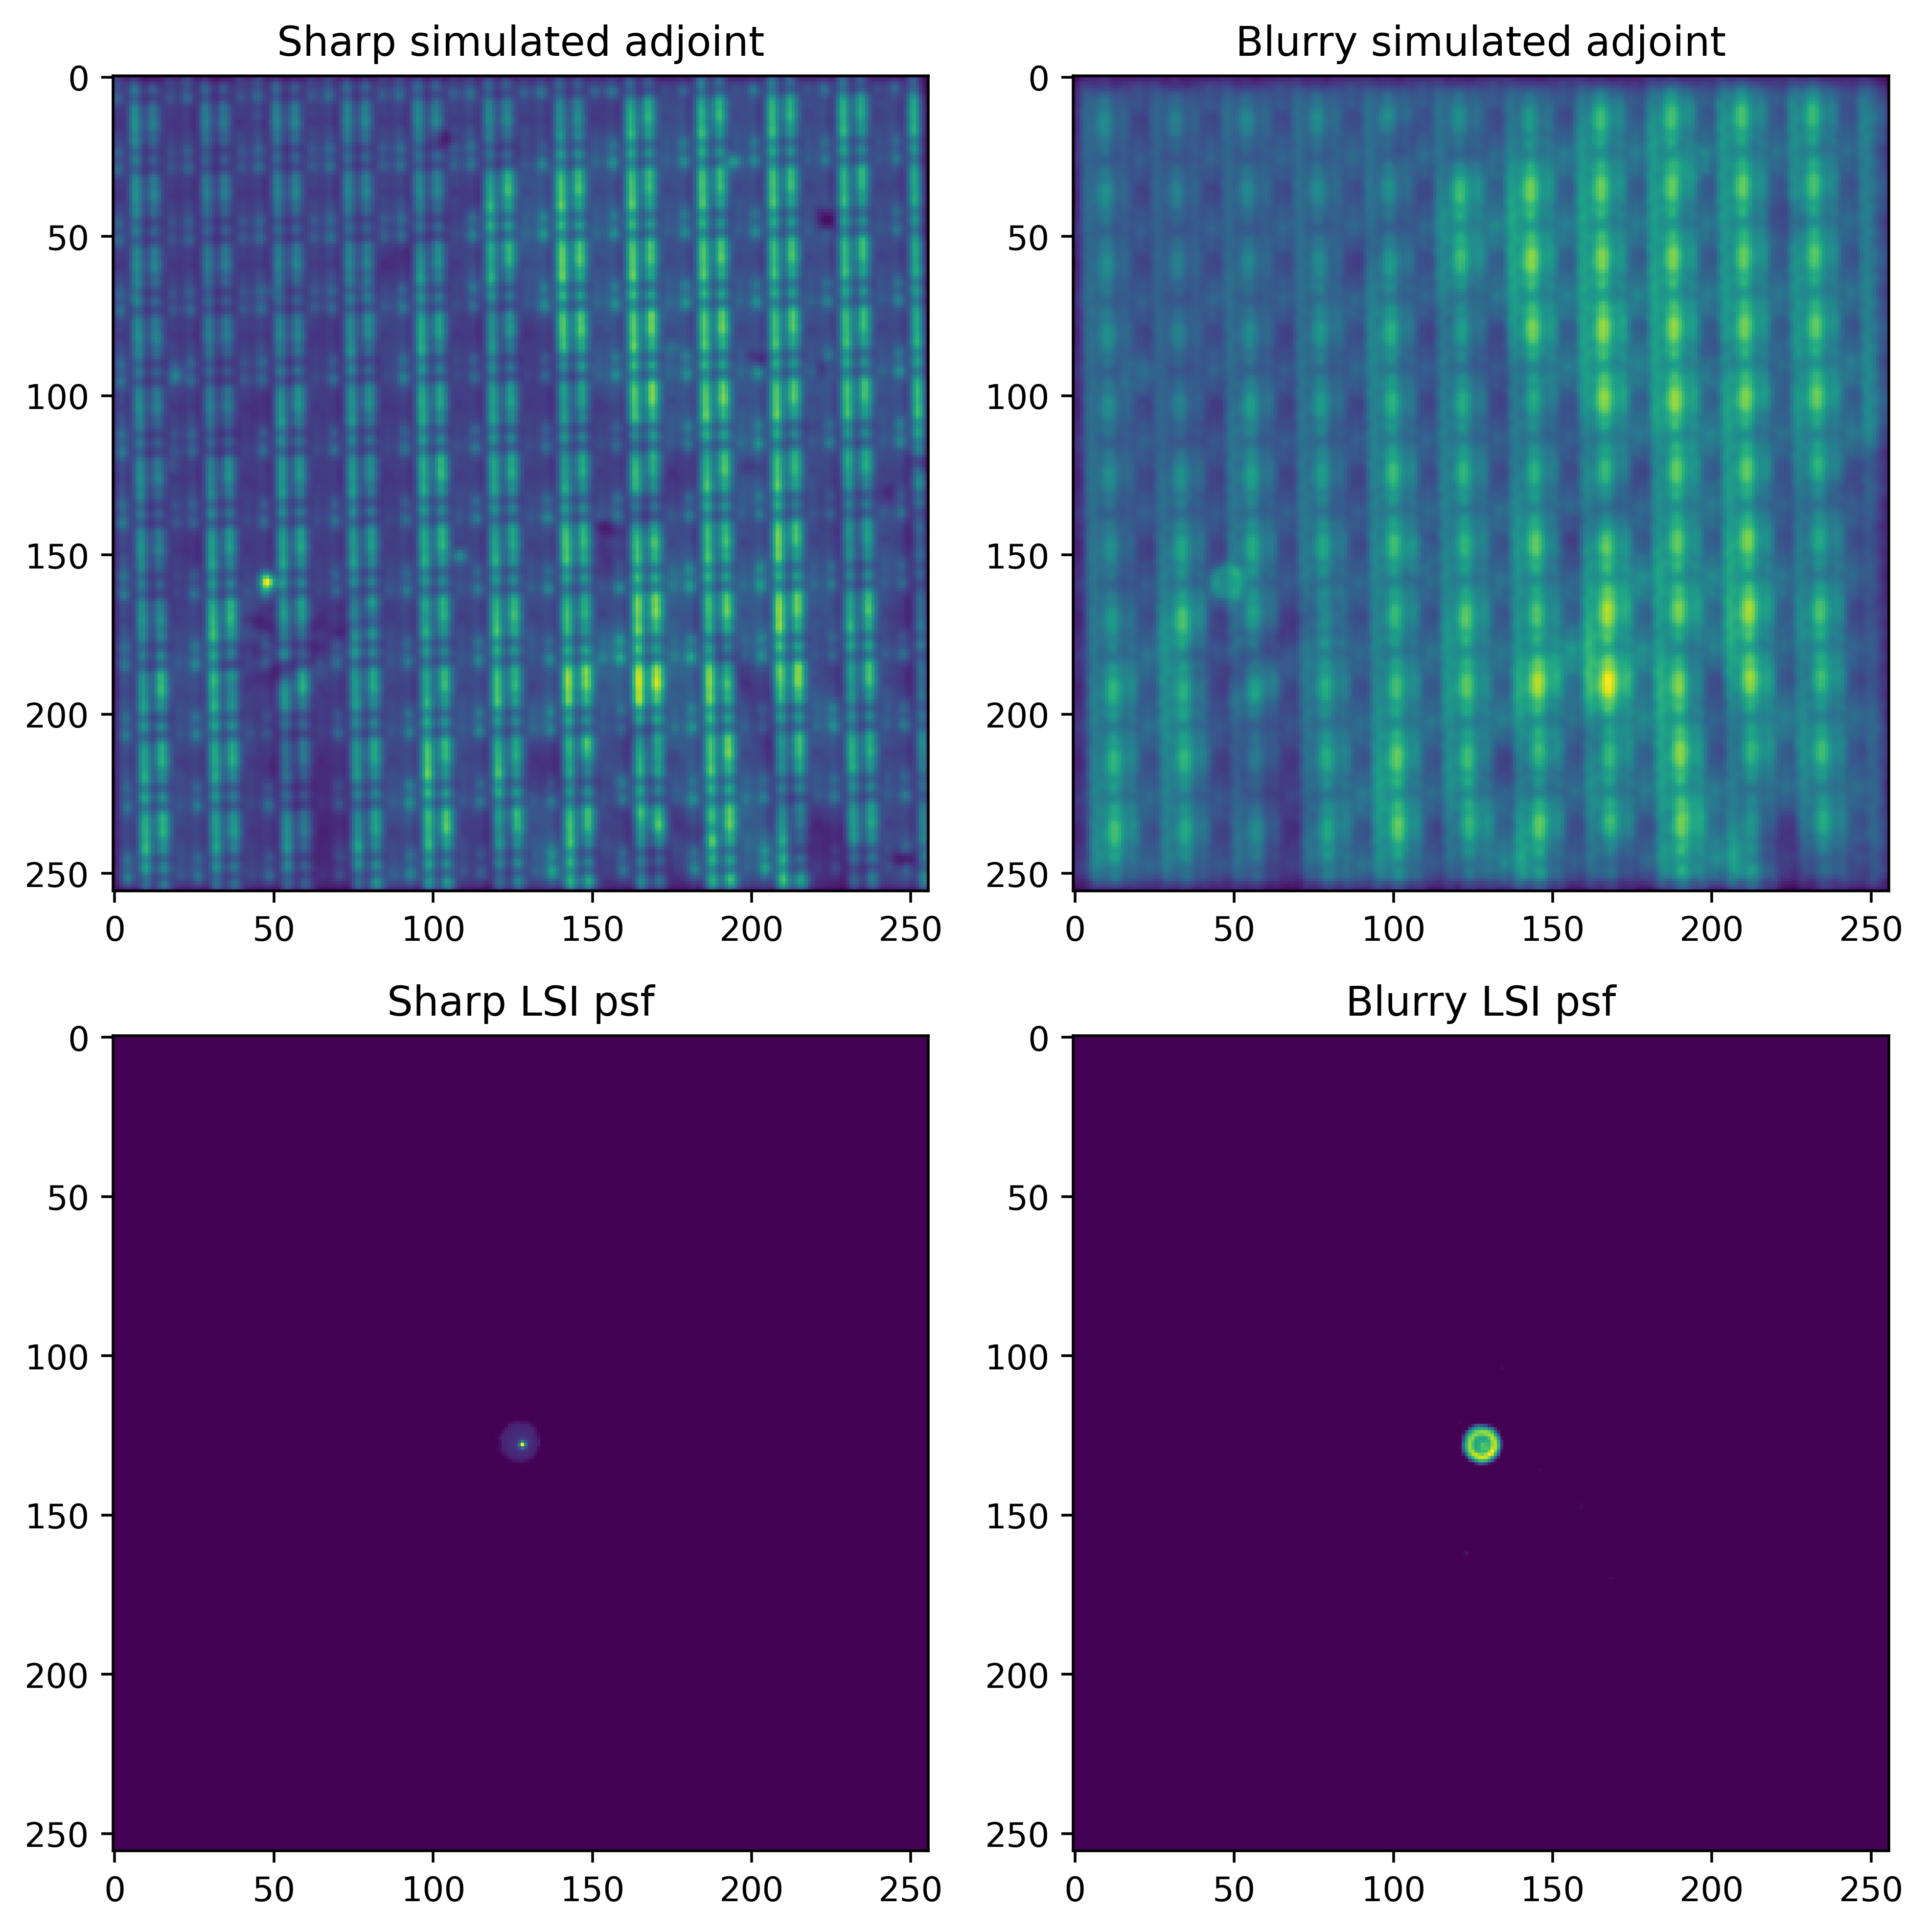

: 

In [12]:
output, psf_data = forward_model.b, forward_model.psfs
print(psf_data.shape)
fig, ax = plt.subplots(2,2, figsize = (8,8))
ax[0,0].imshow(np.mean(output.detach().cpu().numpy()[0,0], 0))
ax[0,0].set_title("Sharp simulated adjoint")
ax[0,1].imshow(np.mean(output.detach().cpu().numpy()[0,1], 0))
ax[0,1].set_title("Blurry simulated adjoint")
ax[1,0].imshow(psf_data.detach().cpu().numpy()[0])
ax[1,0].set_title("Sharp LSI psf")
ax[1,1].imshow(psf_data.detach().cpu().numpy()[-1])
ax[1,1].set_title("Blurry LSI psf")
plt.tight_layout()
plt.show()

And we're done. You should now be able to use these data pairs to train a deep reconstruction model.